## load data

In [1]:
import pandas as pd
df = pd.read_excel('df.xlsx')
df_2  = pd.read_excel('df_2.xlsx')

In [2]:
df.head()

,commnetaire,reaction
0,khayb rihto,negative
1,rihto zwina,pos
2,madhar khayb,negative
3,madhar zwin,pos
4,khaba harcha,negative


In [3]:
df.columns

Index(['commnetaire', 'reaction'], dtype='object')

In [4]:
df_2.rename(columns={'resultat': 'commnetaire', 'sentiment': 'reaction'}, inplace=True)

In [5]:
df['reaction'].value_counts()

reaction
pos         92
negative    76
neutre       5
Name: count, dtype: int64

In [6]:
df_2['reaction'].value_counts()

reaction
neutre      17
positive    16
négative    16
negative     2
positve      1
Name: count, dtype: int64

In [7]:
df_2.head()

,commnetaire,reaction
0,waw hadchi 3ndkom zwin,positive
1,mabihch khaskom tzido fih lma,neutre
2,maprodoui ma ta wza,négative
3,tbarklah 3likom koulchi howa hadak,positive
4,mahlo mamalhe,neutre


In [8]:
df['reaction'] = df['reaction'].apply(lambda x: 'positive' if 'pos' in x.lower() else x)
df_2['reaction'] = df['reaction'].apply(lambda x: 'negative' if 'négative' in x.lower() else x)


In [9]:
condition = df['reaction'] == "neutre"
df = df[~condition]

In [10]:
condition = df_2['reaction'] == "neutre"
df_2 = df_2[~condition]

In [11]:
df = pd.concat([df, df_2], ignore_index=True)
df.shape

(220, 2)

In [12]:
df['reaction'].value_counts()

reaction
positive    118
negative    102
Name: count, dtype: int64

In [13]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# X_train, X_test, y_train, y_test = train_test_split(df['commnetaire'], df['reaction'], test_size=0.2, random_state=42)

# # Créer un vecteur TF-IDF
# vectorizer = TfidfVectorizer()
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)

In [14]:
# # Convertir les données en listes de listes
# X_train_sequences = X_train_tfidf.toarray().tolist()
# X_test_sequences = X_test_tfidf.toarray().tolist()

In [15]:
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, Dropout,Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['reaction'])

# Diviser l'ensemble de données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(df['commnetaire'], df['sentiment_encoded'], test_size=0.2, random_state=42)

# Créer un vecteur TF-IDF
# vectorizer = TfidfVectorizer()
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)

# # Convertir les données en listes de listes
# X_train_sequences = X_train_tfidf.toarray().tolist()
# X_test_sequences = X_test_tfidf.toarray().tolist()

# Tokenization et séquence padding
max_words = 1000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_sequence_length = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

# Créer le modèle LSTM
embedding_dim = 50
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(12,return_sequences=True))
model.add(LSTM(12))
model.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
his = model.fit(X_train_padded, y_train, epochs=64, validation_data=(X_test_padded, y_test))

# Évaluer les performances du modèle
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Précision : {accuracy:.2f}')

Epoch 1/64
6/6 [==============================] - 5s 227ms/step - loss: 0.6936 - accuracy: 0.4830 - val_loss: 0.6914 - val_accuracy: 0.5227
Epoch 2/64
6/6 [==============================] - 0s 16ms/step - loss: 0.6901 - accuracy: 0.5398 - val_loss: 0.6906 - val_accuracy: 0.5227
Epoch 3/64
6/6 [==============================] - 0s 20ms/step - loss: 0.6877 - accuracy: 0.5398 - val_loss: 0.6890 - val_accuracy: 0.5227
Epoch 4/64
6/6 [==============================] - 0s 17ms/step - loss: 0.6823 - accuracy: 0.5455 - val_loss: 0.6868 - val_accuracy: 0.5227
Epoch 5/64
6/6 [==============================] - 0s 16ms/step - loss: 0.6735 - accuracy: 0.5511 - val_loss: 0.6823 - val_accuracy: 0.5227
Epoch 6/64
6/6 [==============================] - 0s 19ms/step - loss: 0.6567 - accuracy: 0.6364 - val_loss: 0.6737 - val_accuracy: 0.5455
Epoch 7/64
6/6 [==============================] - 0s 22ms/step - loss: 0.6258 - accuracy: 0.7386 - val_loss: 0.6590 - val_accuracy: 0.6136
Epoch 8/64
6/6 [==========

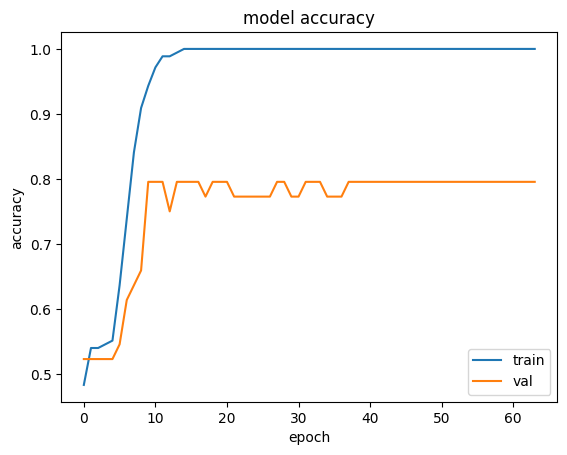

In [20]:
import matplotlib.pyplot as plt
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [18]:
import numpy as np

def predict_sentiment(text, model, tokenizer, max_sequence_length):
    # Tokenization et séquence padding pour le texte d'entrée
    text_sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(text_sequence, maxlen=max_sequence_length, padding='post')

    # Prédiction avec le modèle
    prediction = model.predict(padded_sequence)

    # Convertir la prédiction en classe (0 ou 1)
    predicted_class = np.round(prediction).astype(int)

    # Décoder la classe en label d'origine
    decoded_class = label_encoder.inverse_transform(predicted_class.flatten())

    return decoded_class[0]




In [19]:
texts_to_predict = ['hadchi zwin ','flousso 7lal elih wlh ',' waw nadi ' ,' nqass hadchi endkomm','katflaw ela nass hchoma elikom','3ayan hadchi']
for text_to_predict in texts_to_predict:
    predicted_sentiment = predict_sentiment(text_to_predict, model, tokenizer, max_sequence_length)
    print(f"Texte : {text_to_predict}")
    print(f"Sentiment prédit : {predicted_sentiment}")

    

1/1 [==============================] - 1s 807ms/step
Texte : hadchi zwin 
Sentiment prédit : positive
1/1 [==============================] - 0s 30ms/step
Texte : flousso 7lal elih wlh 
Sentiment prédit : positive
1/1 [==============================] - 0s 32ms/step
Texte :  waw nadi 
Sentiment prédit : positive
1/1 [==============================] - 0s 27ms/step
Texte :  nqass hadchi endkomm
Sentiment prédit : negative
1/1 [==============================] - 0s 23ms/step
Texte : katflaw ela nass hchoma elikom
Sentiment prédit : negative
1/1 [==============================] - 0s 20ms/step
Texte : 3ayan hadchi
Sentiment prédit : negative
